In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install autocorrect

     |████████████████████████████████| 624kB 5.4MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.5.0-cp37-none-any.whl size=621854 sha256=9a372ec56d1b082baf6700ed03cda3dfe7280fee9ca1d854333e4b6ea27c64cb
  Stored in directory: /root/.cache/pip/wheels/1f/71/da/4a15028d25fbd5fb97fb76c5f76f0ad86f0caa69394dd7cfa7
Successfully built autocorrect


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import cv2
from PIL import Image, ImagePath, ImageDraw
import os
import glob
import csv
import pathlib
from pathlib import Path
import re
import math
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Reshape, Dense, GRU, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
import scipy.io as sio
from shapely.geometry import Polygon
from google.colab import files
from keras.models import load_model

import warnings
warnings.filterwarnings("ignore")
colab_path = "/content/drive/MyDrive/"
content_folder = "/content/"

from autocorrect import Speller
spell = Speller(lang='en')

In [ ]:
# train = pd.read_csv('/content/synthtext_icdar/combined_train_data.csv')
# test = pd.read_csv('/content/drive/MyDrive/combined_test_data.csv')

# #vocabulary creation
# l=list(train['gt_path'])
# CLASSES=[]
# for i in tqdm(l):
#     file=open(i)
#     for line in file:
#         line=line.replace('\n','')
#         a=line.split(",")[-1]
#         if a!='':
#             CLASSES.append(a)
# NUM_CLASSES = len(list(set(CLASSES))) 

In [ ]:
NUM_CLASSES = 22553

In [ ]:
def load_annotation(p):
    '''
    load polygon coordinate and text from the text file for corresponding image
    here p is name of image file whose cooresponding annotation we want 
    '''
    text_polys = []
    text_tags = []
    if not os.path.exists(p):
        return np.array(text_polys, dtype=np.float32), np.array(text_tags, dtype=np.int32)
    with open(p, 'r', encoding = 'utf-8-sig') as f:
        #Reading our data
        reader = f.readlines()
        for line in reader:            
            line= line.replace("\n", "")
            line = line.replace('\xef\xbb\bf', '')
            line = line.replace('\xe2\x80\x8d', '')
            line = line.strip()
            line = line.split(',')
            #Taking word level locations to plot bounding box i.e,377,117,463,117,465,130,378,130
            x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
            #Appending coordinates
            text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
            
            
            if len(line) > 9:
                label = ",".join(line[9:])
            else:
                label = line[-1]
                
            #Appending words and ###
            if label == '*' or label == '###' or label == '':
                text_tags.append(None)
            else:
                text_tags.append(label)

        return np.array(text_polys, dtype=np.float32), np.array(text_tags)


# This Function is used to calculate AREA of polygon
def polygon_area(poly):
    '''
    compute area of a polygon
    '''
    edge = [
        (poly[1][0] - poly[0][0]) * (poly[1][1] + poly[0][1]),
        (poly[2][0] - poly[1][0]) * (poly[2][1] + poly[1][1]),
        (poly[3][0] - poly[2][0]) * (poly[3][1] + poly[2][1]),
        (poly[0][0] - poly[3][0]) * (poly[0][1] + poly[3][1])
    ]
    return np.sum(edge)/2.


#https://github.com/argman/EAST/blob/master/icdar.py

def is_polygon(poly):
    for i in range(3):
        p0 = poly[i]

        p1 = poly[(i + 1) % 4]
        p2 = poly[(i + 2) % 4]

        if p0[0] == p1[0] and p1[1] == p0[1]:
            return False
        if p0[0] == p2[0] and p2[1] == p0[1]:
            return False
        if p1[0] == p2[0] and p1[1] == p2[1]:
            return False

        if p0[0] == p1[0]:
            if p1[0] == p2[0]:
                return False
        else:
            if p1[0] != p2[0]:
                k1 = (p1[1] - p0[1]) / (p1[0] - p0[0])
                k2 = (p2[1] - p1[1]) / (p2[0] - p1[0])
                if abs(k1 - k2) < 1e-6:
                    return False
                else:
                    if p1[1] == p2[1]:
                        return False

    return True


#3
# This function is used to discard invalid polygons and check direction of them
# https://github.com/Masao-Taketani/FOTS_OCR


#https://github.com/argman/EAST/blob/master/icdar.py
def check_and_validate_polys(polys, tags, xxx_todo_changeme):
    '''
    check so that the text poly is in the same direction,
    and also filter some invalid polygons
    :param polys:
    :param tags:
    :return:
    '''
    #Taking height and width of the image
    (h, w) = xxx_todo_changeme
    if polys.shape[0] == 0:
        return polys
    polys[:, :, 0] = np.clip(polys[:, :, 0], 0, w-1)
    polys[:, :, 1] = np.clip(polys[:, :, 1], 0, h-1)

    validated_polys = []
    validated_tags = []
    for poly, tag in zip(polys, tags):
        p_area = polygon_area(poly)
        
        # memory error after hitting not a polygon !!!
        if is_polygon(poly) is False:
            #print("not a polygon: ", poly)
            continue
        
        if abs(p_area) < 1:
#             print('invalid poly')
            continue
        if p_area > 0:
#             print('poly in wrong direction')
            poly = poly[(0, 3, 2, 1), :]
        validated_polys.append(poly)
        validated_tags.append(tag)
        
    return np.array(validated_polys), validated_tags

#https://github.com/argman/EAST/blob/master/icdar.py

#This function is implementation of Polygon Shrinkage Algorithm 
def shrink_poly(poly, r):
    '''
    fit a poly inside the origin poly
    used for generate the score map
    '''
    # shrink ratio
    R = 0.3
    # find the longer pair
    if np.linalg.norm(poly[0] - poly[1]) + np.linalg.norm(poly[2] - poly[3]) > \
                    np.linalg.norm(poly[0] - poly[3]) + np.linalg.norm(poly[1] - poly[2]):
        # first move (p0, p1), (p2, p3), then (p0, p3), (p1, p2)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
        ## p0, p3
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
    else:
        ## p0, p3
        # print poly
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
    return poly



#Compute distance between p1-p2 and p3
def point_dist_to_line(p1, p2, p3):
    '''compute the distance from p3 to p1-p2'''
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)

#Find equation of line using two 2D points p1 and p2
def fit_line(p1, p2):
    '''fit a line ax+by+c = 0'''
    if p1[0] == p1[1]:
        return [1., 0., -p1[0]]
    else:
        [k, b] = np.polyfit(p1, p2, deg=1)
        return [k, -1., b]

#Find Intersection poitn of 2 lines
def line_cross_point(line1, line2):
    '''line1 0= ax+by+c, compute the cross point of line1 and line2'''
    if line1[0] != 0 and line1[0] == line2[0]:
        print('Cross point does not exist')
        return None
    if line1[0] == 0 and line2[0] == 0:
        print('Cross point does not exist')
        return None
    if line1[1] == 0:
        x = -line1[2]
        y = line2[0] * x + line2[2]
    elif line2[1] == 0:
        x = -line2[2]
        y = line1[0] * x + line1[2]
    else:
        k1, _, b1 = line1
        k2, _, b2 = line2
        x = -(b1-b2)/(k1-k2)
        y = k1*x + b1
    return np.array([x, y], dtype=np.float32)

#Get Equation of line that is perpendicular to line passing through a point
def line_verticle(line, point):
    '''get the verticle line from line across point'''
    if line[1] == 0:
        verticle = [0, -1, point[1]]
    else:
        if line[0] == 0:
            verticle = [1, 0, -point[0]]
        else:
            verticle = [-1./line[0], -1, point[1] - (-1/line[0] * point[0])]
    return verticle

# Convert a parallelogram to rectangle
def rectangle_from_parallelogram(poly):
    '''
    fit a rectangle from a parallelogram
    '''
    p0, p1, p2, p3 = poly
    angle_p0 = np.arccos(np.dot(p1-p0, p3-p0)/(np.linalg.norm(p0-p1) * np.linalg.norm(p3-p0)))
    if angle_p0 < 0.5 * np.pi:
        if np.linalg.norm(p0 - p1) > np.linalg.norm(p0-p3):
            # p0 and p2
            ## p0
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p0)

            new_p3 = line_cross_point(p2p3, p2p3_verticle)
            ## p2
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p2)

            new_p1 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
        else:
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p0)

            new_p1 = line_cross_point(p1p2, p1p2_verticle)
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p2)

            new_p3 = line_cross_point(p0p3, p0p3_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
    else:
        if np.linalg.norm(p0-p1) > np.linalg.norm(p0-p3):
            # p1 and p3
            ## p1
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p1)

            new_p2 = line_cross_point(p2p3, p2p3_verticle)
            ## p3
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p3)

            new_p0 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)
        else:
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p1)

            new_p0 = line_cross_point(p0p3, p0p3_verticle)
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p3)

            new_p2 = line_cross_point(p1p2, p1p2_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)

#Sorting a rectangle to get all point in clockwies manner
def sort_rectangle(poly):
    '''sort the four coordinates of the polygon, points in poly should be sorted clockwise'''
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            #this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle


def restore_rectangle_rbox(origin, geometry):
    ''' Resotre rectangle tbox'''
    d = geometry[:, :4]
    angle = geometry[:, 4]
    # for angle > 0
    origin_0 = origin[angle >= 0]
    d_0 = d[angle >= 0]
    angle_0 = angle[angle >= 0]
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])


#Some geometrical functions used in codes
def restore_rectangle(origin, geometry):
    return restore_rectangle_rbox(origin, geometry)

def getRotateRect(box):
    rect = cv2.minAreaRect(box)

    angle=rect[2]  # angle = [-90, 0)
    if angle < -45:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        angle += 90
        size = (rect[1][1],rect[1][0])
    else:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        size=rect[1]

    box_ = cv2.boxPoints(rect)
    return np.concatenate([rect[0], size]), angle, box_


#These Functions are used to Generate ROI params like out box,crop box & angles that we use to crop text from image
def generate_roiRotatePara(box, angle, expand_w = 60):
    '''Generate all ROI Parameterts'''
    p0_rect, p1_rect, p2_rect, p3_rect = box
    cxy = (p0_rect + p2_rect) / 2.
    size = np.array([np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p0_rect - p3_rect)])
    rrect = np.concatenate([cxy, size])

    box=np.array(box)

    points=np.array(box, dtype=np.int32)
    xmin=np.min(points[:,0])
    xmax=np.max(points[:,0])
    ymin=np.min(points[:,1])
    ymax=np.max(points[:,1])
    bbox = np.array([xmin, ymin, xmax, ymax])
    if np.any(bbox < -expand_w):
        return None
    
    rrect[:2] -= bbox[:2]
    rrect[:2] -= rrect[2:] / 2
    rrect[2:] += rrect[:2]

    bbox[2:] -= bbox[:2]

    rrect[::2] = np.clip(rrect[::2], 0, bbox[2])
    rrect[1::2] = np.clip(rrect[1::2], 0, bbox[3])
    rrect[2:] -= rrect[:2]
    
    return bbox.astype(np.int32), rrect.astype(np.int32), - angle

def restore_roiRotatePara(box):
    rectange, rotate_angle = sort_rectangle(box)
    return generate_roiRotatePara(rectange, rotate_angle)

#This function is used to generate geo_map,score_map, training_mask,corp_box,out_box,angle that we use while training model
def generate_rbox(im_size, polys, tags):
    '''Genrate score_map and geo_map for image'''
    h, w = im_size
    poly_mask = np.zeros((h, w), dtype=np.uint8)
    score_map = np.zeros((h, w), dtype=np.uint8)
    geo_map = np.zeros((h, w, 5), dtype=np.float32)

    outBoxs = []
    cropBoxs = []
    angles = []
    text_tags = []
    recg_masks = []
    # mask used during traning, to ignore some hard areas
    training_mask = np.ones((h, w), dtype=np.uint8)
    for poly_idx, poly_tag in enumerate(zip(polys, tags)):
        poly = poly_tag[0]
        #print(poly)
        tag = poly_tag[1]
        #print(tag)
        r = [None, None, None, None]
        for i in range(4):
            r[i] = min(np.linalg.norm(poly[i] - poly[(i + 1) % 4]),
                       np.linalg.norm(poly[i] - poly[(i - 1) % 4]))
        # score map
        shrinked_poly = shrink_poly(poly.copy(), r).astype(np.int32)[np.newaxis, :, :]
        cv2.fillPoly(score_map, shrinked_poly, 1)
        cv2.fillPoly(poly_mask, shrinked_poly, poly_idx + 1)

        # if geometry == 'RBOX':
        # generate a parallelogram for any combination of two vertices
        fitted_parallelograms = []
        for i in range(4):
            p0 = poly[i]
            p1 = poly[(i + 1) % 4]
            p2 = poly[(i + 2) % 4]
            p3 = poly[(i + 3) % 4]
            edge = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            backward_edge = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            forward_edge = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            if point_dist_to_line(p0, p1, p2) > point_dist_to_line(p0, p1, p3):
                #  parallel lines through p2
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p2[0]]
                else:
                    edge_opposite = [edge[0], -1, p2[1] - edge[0] * p2[0]]
            else:
                # after p3
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p3[0]]
                else:
                    edge_opposite = [edge[0], -1, p3[1] - edge[0] * p3[0]]
            # move forward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p2 = line_cross_point(forward_edge, edge_opposite)
            if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
                # across p0
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p0[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p0[1] - forward_edge[0] * p0[0]]
            else:
                # across p3
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p3[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p3[1] - forward_edge[0] * p3[0]]
            new_p0 = line_cross_point(forward_opposite, edge)
            new_p3 = line_cross_point(forward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
            # or move backward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p3 = line_cross_point(backward_edge, edge_opposite)
            if point_dist_to_line(p0, p3, p1) > point_dist_to_line(p0, p3, p2):
                # across p1
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p1[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p1[1] - backward_edge[0] * p1[0]]
            else:
                # across p2
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p2[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p2[1] - backward_edge[0] * p2[0]]
            new_p1 = line_cross_point(backward_opposite, edge)
            new_p2 = line_cross_point(backward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
        areas = [Polygon(t).area for t in fitted_parallelograms]
        parallelogram = np.array(fitted_parallelograms[np.argmin(areas)][:-1], dtype=np.float32)
        # sort thie polygon
        parallelogram_coord_sum = np.sum(parallelogram, axis=1)
        min_coord_idx = np.argmin(parallelogram_coord_sum)
        parallelogram = parallelogram[
            [min_coord_idx, (min_coord_idx + 1) % 4, (min_coord_idx + 2) % 4, (min_coord_idx + 3) % 4]]

        rectange = rectangle_from_parallelogram(parallelogram)
        rectange, rotate_angle = sort_rectangle(rectange)

        p0_rect, p1_rect, p2_rect, p3_rect = rectange

        # if the poly is too small, then ignore it during training
        poly_h = min(np.linalg.norm(p0_rect - p3_rect), np.linalg.norm(p1_rect - p2_rect))
        poly_w = min(np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p2_rect - p3_rect))

        invaild = (min(poly_h, poly_w) < 6) or tag is None or (True and poly_h > poly_w * 2)

        if invaild:
            cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)
        xy_in_poly = np.argwhere(poly_mask == (poly_idx + 1))
        
        if not invaild:
            roiRotatePara = generate_roiRotatePara(rectange, rotate_angle)
            if roiRotatePara:
                outBox, cropBox, angle = roiRotatePara
                if min(cropBox[2:]) > 6:
                    w , h = cropBox[2:]
                    textImgW = np.ceil(min(w / float(h) * 32, 256) / 4 /1)
                    #print(tag)
                    if textImgW >= 2 * min(len(tag), 16):  # avoid CTC error
                        outBoxs.append(outBox)
                        cropBoxs.append(cropBox)
                        angles.append(angle)
                        text_tags.append(tag[:16])
                        recg_masks.append(1.)

        for y, x in xy_in_poly:
            point = np.array([x, y], dtype=np.float32)
            # top
            geo_map[y, x, 0] = point_dist_to_line(p0_rect, p1_rect, point) + 3
            # right
            geo_map[y, x, 1] = point_dist_to_line(p1_rect, p2_rect, point) + 3
            # down
            geo_map[y, x, 2] = point_dist_to_line(p2_rect, p3_rect, point) + 3
            # left
            geo_map[y, x, 3] = point_dist_to_line(p3_rect, p0_rect, point) + 3
            # angle
            geo_map[y, x, 4] = rotate_angle
    if len(outBoxs) == 0:
        outBoxs.append([0, 0, 2 * 4, 2 * 4]) # keep extract From sharedConv feature map not zero
        cropBoxs.append([0, 0, 2 * 4, 2 * 4])
        angles.append(0.)
        text_tags.append([NUM_CLASSES - 2])
        recg_masks.append(0.)

    outBoxs = np.array(outBoxs, np.int32)
    cropBoxs = np.array(cropBoxs, np.int32)
    angles = np.array(angles, np.float32)

    return score_map, geo_map, training_mask, (outBoxs, cropBoxs, angles), text_tags, recg_masks
    



# Text Detection

In [ ]:
# This is dice coefficient loss used to classify point as text and non text region 

#https://github.com/Masao-Taketani/FOTS_OCR/blob/master/module/Backbone_branch.py
def dice_coefficient(y_true_cls, y_pred_cls,training_mask):
    '''
    dice loss
    :param y_true_cls:
    :param y_pred_cls:
    :param training_mask:x
    :return:
    '''
    eps = 10**-6
    intersection = tf.reduce_sum(y_true_cls * y_pred_cls * training_mask)
    
    union = tf.reduce_sum(y_true_cls * training_mask) + tf.reduce_sum(y_pred_cls * training_mask) + eps
    loss = 1. - (2 * intersection / union)
    return loss


#https://github.com/Masao-Taketani/FOTS_OCR/blob/master/module/Backbone_branch.py
def rbox_loss(y_true_cls,y_true_geo,y_pred_geo,training_mask):
  # d1 -> top, d2->right, d3->bottom, d4->left
  d1_gt, d2_gt, d3_gt, d4_gt, theta_gt = tf.split(value=y_true_geo, num_or_size_splits=5, axis=3)
  d1_pred, d2_pred, d3_pred, d4_pred, theta_pred = tf.split(value=y_pred_geo, num_or_size_splits=5, axis=3)

  area_gt = (d1_gt + d3_gt) * (d2_gt + d4_gt)
  area_pred = (d1_pred + d3_pred) * (d2_pred + d4_pred)
  w_union = tf.minimum(d2_gt, d2_pred) + tf.minimum(d4_gt, d4_pred)
  h_union = tf.minimum(d1_gt, d1_pred) + tf.minimum(d3_gt, d3_pred)
  area_intersect = w_union * h_union
  area_union = area_gt + area_pred - area_intersect

  L_AABB = -tf.math.log((area_intersect + 1.0) / (area_union + 1.0))
  L_theta = 1 - tf.cos(theta_pred - theta_gt)

  L_g = L_AABB +  50*L_theta
  L_g=tf.squeeze(L_g,axis=3)

  return tf.reduce_mean(L_g * y_true_cls * training_mask)


#This class contains complete loss we have used for text Detection Branch
class total_Loss(tf.keras.losses.Loss):
  def __init__(self, from_logits=False,reduction=tf.keras.losses.Reduction.AUTO,name='Loss_layer'):
      super(total_Loss, self).__init__(reduction=reduction, name=name)
  def call(self, y_true, y_pred):
    
    #Getting geo_map and score_maps
    y_true_cls=y_true[:,:,:,0]
    y_pred_cls=y_pred[:,:,:,0]
    y_pred_geo=y_pred[:,:,:,1:6]
    y_true_geo=y_true[:,:,:,1:6]
    training_mask=y_true[:,:,:,6]
    
    #1. Dice Loss
    dice_loss = dice_coefficient(y_true_cls, y_pred_cls, training_mask)
    # we scale classification loss by factor of 0.01 to match the iou loss part
    dice_loss *=0.01

    rbox_loss_ = rbox_loss(y_true_cls,y_true_geo,y_pred_geo,training_mask)
    
     
    return 100*(rbox_loss_ + dice_loss)


## NMS

In [ ]:
#These Are Function that will be used while converting geo_maps to score_maps and returns bounding boxes for image after nms
#https://github.com/argman/EAST/blob/master/eval.py
def sort_poly(p):
  min_axis = np.argmin(np.sum(p, axis=1))
  p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
  if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
    return p
  else:
    return p[[0, 3, 2, 1]]


#https://github.com/argman/EAST/blob/master/locality_aware_nms.py
def intersection(g, p):
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter/union


def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8])/(g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g


def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds+1]

    return S[keep]


def nms_locality(polys, thres=0.3):
    '''
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
  
    for g in polys:
        if p is not None and intersection(g, p) > thres:
        
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
  
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    
    return standard_nms(np.array(S), thres)

# Text Recognition

In [ ]:
#Preparing vocabulary for Text Recognition Branch
#https://github.com/qjadud1994/CRNN-Keras/blob/master/Model_GRU.py
TOTAL_CHARS = " 0123456789abcdefghijklmnopqrstuvwxyzéABCDEFGHIJKLMNOPQRSTUVWXYZÉ´-~`<>'.:;^/|!?$%#@&*()[]{}_+=,\\\""
NUM_CLASSES = len(TOTAL_CHARS) 
char_index={}
index_char={}
for i,val in enumerate(TOTAL_CHARS):
  index_char[i+1]=val
  char_index[val]=i+1

In [ ]:
#This class contains complete loss we have used for text Detection Branch
class ctc_loss(tf.keras.losses.Loss):
  def __init__(self, from_logits=False,reduction=tf.keras.losses.Reduction.AUTO,name='Loss_layer'):
      super(ctc_loss, self).__init__(reduction=reduction, name=name)
  def call(self, y_true, y_pred):
    
    #Getting geo_map and score_maps
    label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True)
    return tf.keras.backend.ctc_batch_cost(y_true,y_pred,np.ones((128,1),'int32')*64,label_length)

# Model Loading

In [ ]:
model_resnet = load_model('/content/drive/MyDrive/detection_and_recognition_final_model_syntext/detect_fourth_model_resnet.h5', custom_objects={'total_Loss': total_Loss()})
recg_model = load_model('/content/drive/MyDrive/detection_and_recognition_final_model_syntext/text_recognition_best_new_model.h5', custom_objects={'ctc_loss': ctc_loss()})

# Final Pipeline

In [ ]:
def recognize_image(img):
  if not isinstance(img, np.ndarray):
    img = img.numpy()

  img = cv2.detailEnhance(img) #pre processing img
  img = cv2.resize(img, (128,64),cv2.INTER_NEAREST) #resizing
  img = np.expand_dims(img, axis = 0) #expanding dims to accomodate batch size
  prediction = recg_model.predict(img) #predicting, shape after prediction = (1, 64, 100)

  # use CTC decoder
  #https://github.com/TheAILearner/A-CRNN-model-for-Text-Recognition-in-Keras/blob/master/CRNN%20Model.ipynb
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                          greedy=True)[0][0])
  final_word = []
  for i in out[0]:
    if i != -1:
      final_word.append(index_char[i])

  final_prediction = "".join(final_word)
  final_preds = spell(final_prediction)
  return final_preds

In [ ]:
#https://github.com/argman/EAST/blob/master/eval.py
# Inference pipeline function used for generating predicted bounding boxes on image for text detection
def FinalPipeline(img):
  
  #Text Detection
  img=cv2.resize(img,(512,512))
  img_for_predict = img
  ii=model_resnet.predict(np.expand_dims(img,axis=0))
  score_map=ii[0][:,:,0]
  geo_map=ii[0][:,:,1:]

  for ind in [0,1,2,3,4]:
    geo_map[:,:,ind]*=score_map

  #ROI Rotate  
  score_map_thresh=0.5
  box_thresh=0.1 
  nms_thres=0.2
  if len(score_map.shape) == 4:
    score_map = score_map[0, :, :, 0]
    geo_map = geo_map[0, :, :, :]


  #filter the score map
  xy_text = np.argwhere(score_map > score_map_thresh)

  # sort the text boxes via the y axis
  xy_text = xy_text[np.argsort(xy_text[:, 0])]

  # restore
  text_box_restored = restore_rectangle(xy_text[:, ::-1], geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
  boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
  boxes[:, :8] = text_box_restored.reshape((-1, 8))
  boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
  boxes = nms_locality(boxes.astype(np.float64), nms_thres)

  # here we filter some low score boxes by the average score map, this is different from the orginal paper
  for i, box in enumerate(boxes):
    mask = np.zeros_like(score_map, dtype=np.uint8)
    cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32), 1)
    boxes[i, 8] = cv2.mean(score_map, mask)[0]
  
    if i==4:
      break
  if len(boxes)>0:
    boxes = boxes[boxes[:, 8] > box_thresh]
  boxes[:,:8:2] = np.clip(boxes[:,:8:2], 0, 512 - 1)
  boxes[:,1:8:2] = np.clip(boxes[:,1:8:2], 0, 512 - 1)  

  res = []
  result = []
  if len(boxes)>0:
    for box in boxes:
      box_ =  box[:8].reshape((4, 2))
      if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
        continue
      result.append(box_)
  res.append(np.array(result, np.float32))   

  box_index = []
  brotateParas = []
  filter_bsharedFeatures = []
  for i in range(len(res)):
    rotateParas = []
    rboxes=res[i]
    txt=[]
    for j, rbox in enumerate(rboxes):
      para = restore_roiRotatePara(rbox)
      if para and min(para[1][2:]) > 8:
        rotateParas.append(para)
        box_index.append((i, j))

  pts=[]   
  #Text Recognition (From boxes given by Text Detection+ROI Rotate) 
  if len(rotateParas) > 0:
      for num in range(len(rotateParas)):
        text=""
        out=rotateParas[num][0]
        crop=rotateParas[num][1]
        points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
        pts.append(points)

  # #Labeling detected and Recognized Text in Image
  predicted_words = []
  for i in range(len(pts)):
      try:
          outs = pts[i]
          [[x1, y1], [x2, y2], [x3, y3], [x4, y4]] = outs
          #https://stackoverflow.com/questions/54884289/how-do-i-crop-an-image-given-the-coordinates-of-the-four-corners-to-crop/54885575
          top_left_x = min([x1,x2,x3,x4])
          top_left_y = min([y1,y2,y3,y4])
          bot_right_x = max([x1,x2,x3,x4])
          bot_right_y = max([y1,y2,y3,y4])

          img_to_pred = imax[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
          predicted_word = recognize_image(img_to_pred) #recognizing text
          predicted_words.append(predicted_word)
      
          cv2.polylines(img,[pts[i]],isClosed=True,color=(0,255,0),thickness=2)

          x, y = outs[0][0], outs[0][1]  #getting the first coordinate of the bounding box
          (w,h) = cv2.getTextSize(predicted_word, cv2.FONT_HERSHEY_PLAIN, 1.5, 1)[0] #getting text size

          text_box = ((x,y), (x + w + 2, y - h - 2))

          #https://www.geeksforgeeks.org/python-opencv-cv2-rectangle-method/
          #https://www.geeksforgeeks.org/python-opencv-cv2-puttext-method/
          cv2.rectangle(img, text_box[0],text_box[1], (255, 255, 255), cv2.FILLED) #creating a box for writing text
          cv2.putText(img, predicted_word, (x,y), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 1) #adding text on top of the box
      except:
          continue

  return img, predicted_words   


In [ ]:
test_images = '/content/drive/MyDrive/20_test_images'

test_images_path = []
for i in os.listdir(test_images):
    test_images_path.append(test_images + "/" + i)

Cause: could not parse the source code of <function <lambda> at 0x7fba67a74680>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fba67a74680>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fba67a74170>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fba67a74170>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


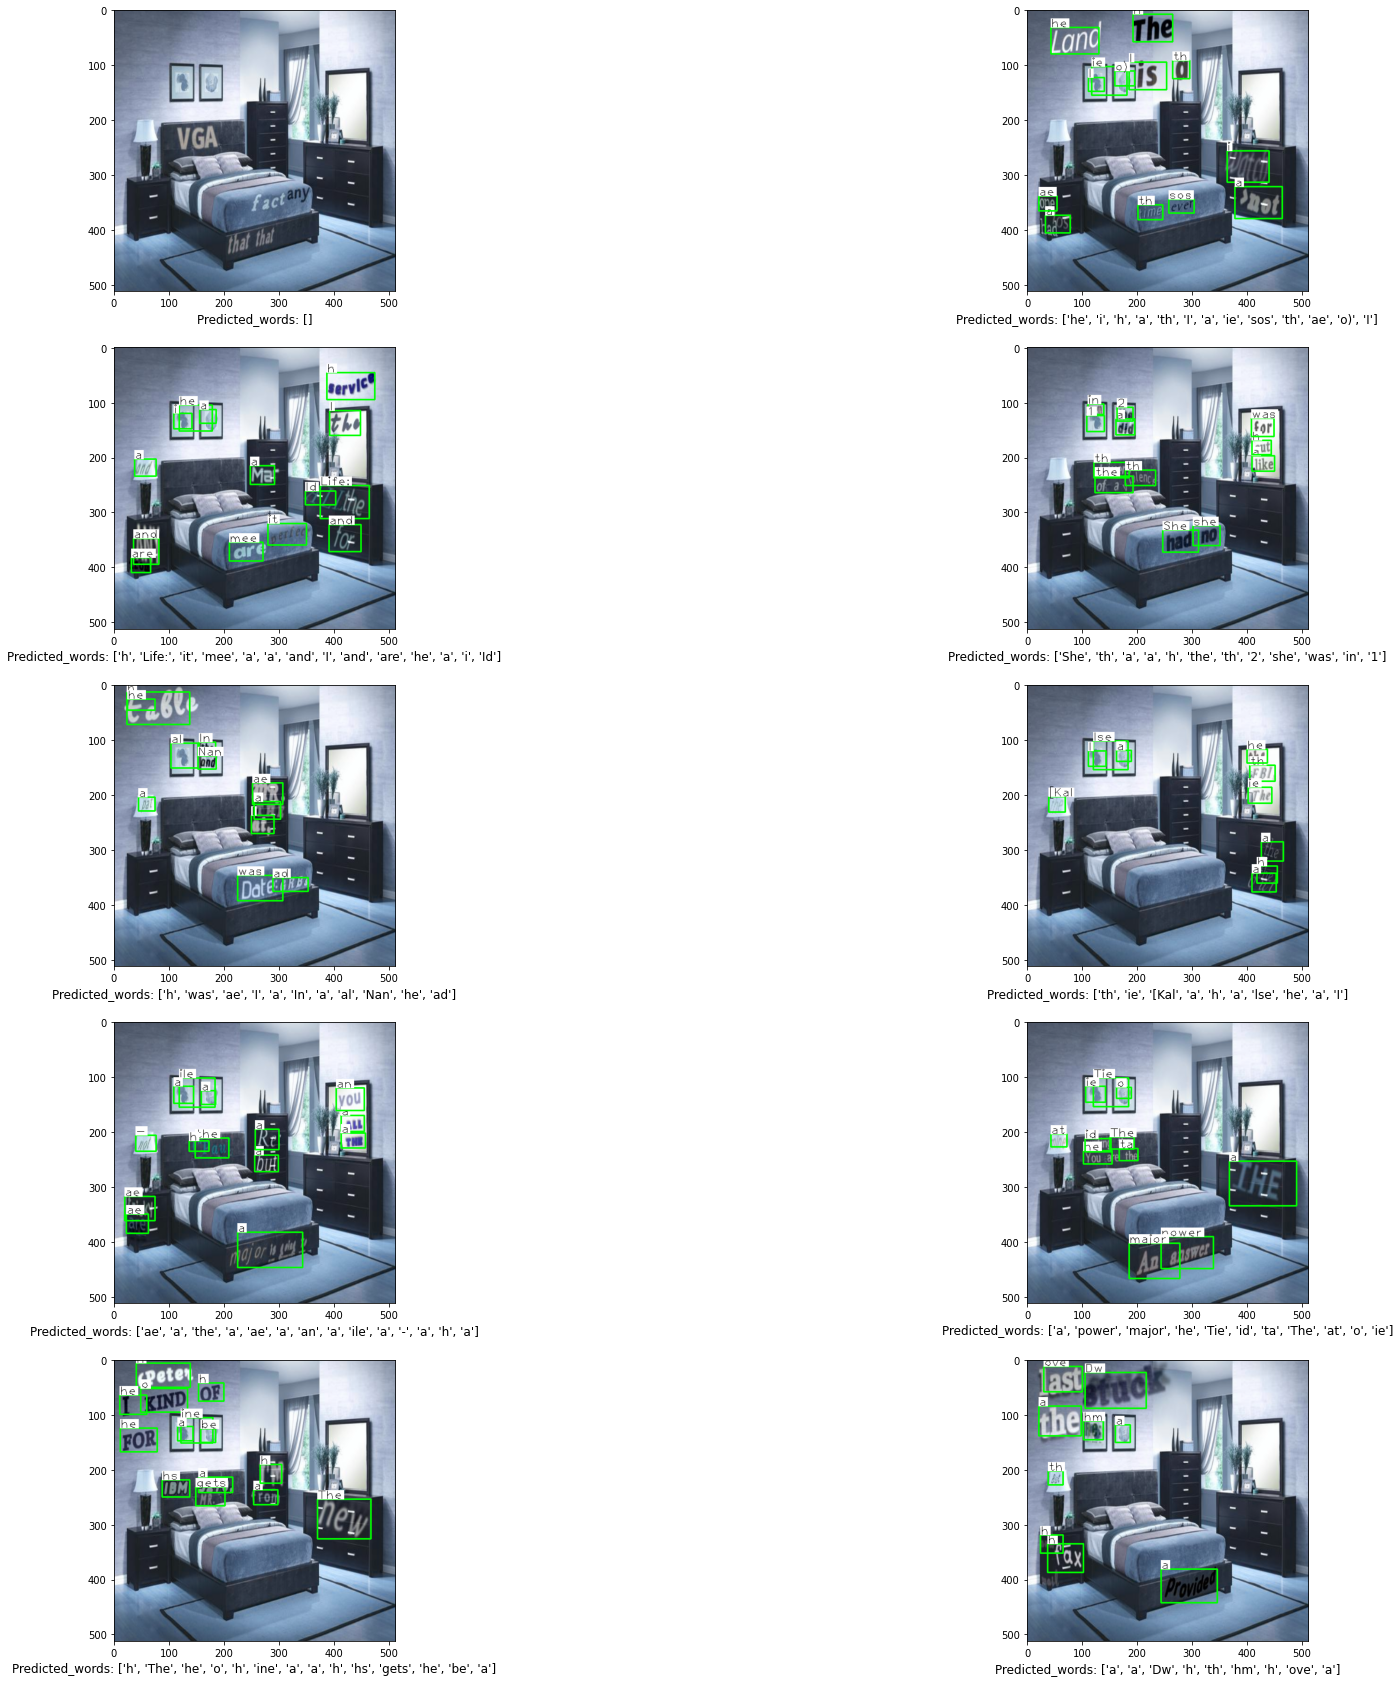

In [ ]:
plt.figure(figsize = (30, 30))
count = 1
for i in range(10):
    plt.subplot(5, 2, count)
    img = cv2.imread(test_images_path[i])
    imax, predicted_words = FinalPipeline(img)
    plt.imshow(imax)
    plt.xlabel(f"Predicted_words: {predicted_words}", fontsize = 12)
    count += 1

predicted_words:  ['a', 'the', 'yi', 'add', 'a', 'a', 'th', 'h', 'he', 'h', 'hay', 'ae', 'h']


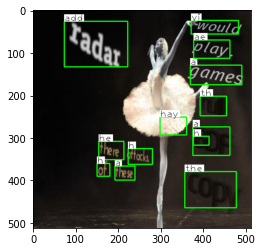

In [ ]:
imax = cv2.imread('/content/ballet_8_0.jpg', cv2.IMREAD_UNCHANGED)
returned_imax, predicted_words = FinalPipeline(imax)
plt.imshow(returned_imax)
print("predicted_words: ", predicted_words)
plt.show()

predicted_words:  ['on', 'h', 'if', 'Ie', 'yo', 'h', 'a', 'he', 'h', 'he', 'h', 'he']


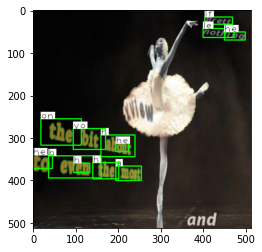

In [ ]:
imax = cv2.imread('/content/ballet_8_32.jpg', cv2.IMREAD_UNCHANGED)
returned_imax, predicted_words = FinalPipeline(imax)
plt.imshow(returned_imax)
print("predicted_words: ", predicted_words)
plt.show()